In [102]:
import os, json
import pandas as pd
import numpy as np
import glob
pd.set_option('display.max_colwidth', 500)

In [103]:
pwd

'/home/jovyan/Documents/MGTA 415 - Analyzing Unstructured Data/final_project'

Link to dataset: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/NMT4HP

In [104]:
def get_tagged_data(data_path, party):
    json_file_path = data_path + party + '/'
    json_pattern = os.path.join(json_file_path,'*.json')
    file_list = glob.glob(json_pattern)

    dfs = [] # an empty list to store the data frames
    col_list = ['fullname', 'user', 'text', 'retweets', 'likes', 'replies', 'timestamp']
    for file in file_list:
        data = pd.read_json(file) # read data frame from json file
        dfs.append(data[col_list]) # append the data frame to the list
        print('Appended '+ file)

    data = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.
    print('Concatenated all senator tweets into a single data frame')
    data['party'] = party
    print('Added party affliation')
    return data

In [105]:
data_path = './dataverse_files/US115thcongress/'

In [106]:
dem_data = get_tagged_data(data_path, 'Democrat')

Appended ./dataverse_files/US115thcongress/Democrat/SenKamalaHarris_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/SenatorCantwell_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/ChrisCoons_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/SenTinaSmith_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/timkaine_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/SenSchumer_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/SenCortezMasto_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/SenBobCasey_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/SenGaryPeters_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/SenDonnelly_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/SenatorCardin_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/SenatorTomUdall_twitter.json
Appended ./dataverse_files/US115thcongress/Democrat/brianscha

In [107]:
rep_data = get_tagged_data(data_path, 'Republican')

Appended ./dataverse_files/US115thcongress/Republican/jiminhofe_twitter.json
Appended ./dataverse_files/US115thcongress/Republican/BenSasse_twitter.json
Appended ./dataverse_files/US115thcongress/Republican/SenShelby_twitter.json
Appended ./dataverse_files/US115thcongress/Republican/SenatorRounds_twitter.json
Appended ./dataverse_files/US115thcongress/Republican/SenThadCochran_twitter.json
Appended ./dataverse_files/US115thcongress/Republican/SenJonKyl_twitter.json
Appended ./dataverse_files/US115thcongress/Republican/SenJohnKennedy_twitter.json
Appended ./dataverse_files/US115thcongress/Republican/SenPatRoberts_twitter.json
Appended ./dataverse_files/US115thcongress/Republican/SenTedCruz_twitter.json
Appended ./dataverse_files/US115thcongress/Republican/SenateMajLdr_twitter.json
Appended ./dataverse_files/US115thcongress/Republican/SenRobPortman_twitter.json
Appended ./dataverse_files/US115thcongress/Republican/SenToomey_twitter.json
Appended ./dataverse_files/US115thcongress/Republic

In [161]:
senator_tweet_data = pd.concat([dem_data, rep_data], ignore_index=True)

In [109]:
senator_tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79409 entries, 0 to 79408
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fullname   79409 non-null  object        
 1   user       79409 non-null  object        
 2   text       79409 non-null  object        
 3   retweets   79409 non-null  int64         
 4   likes      79409 non-null  int64         
 5   replies    79409 non-null  int64         
 6   timestamp  79409 non-null  datetime64[ns]
 7   party      79409 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 4.8+ MB


In [110]:
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
import json
from collections import Counter
import preprocessor as p
from ekphrasis.classes.segmenter import Segmenter

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [162]:
# separate hashtags into a separate column
senator_tweet_data['hashtag'] = senator_tweet_data['text'].apply(lambda x: re.findall(r"#(\w+)", x))

In [163]:
#we preprocess the tweets by removing emojis and picture links. Https links have already been removed in the data
for i,v in enumerate(senator_tweet_data['text']):
    senator_tweet_data.loc[i,'clean_text'] = p.clean(v)

In [115]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [113]:
def preprocess_data(data):
    #Removes Numbers
    data = data.astype(str).str.replace('\d+', '')
    
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer()

    def lemmatize_text(text):
        return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]
    
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    
    return pd.DataFrame(words)

In [164]:
pre_tweets = preprocess_data(senator_tweet_data['clean_text'])
senator_tweet_data['clean_text'] = pre_tweets

/tmp/ipykernel_82/2237715577.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.astype(str).str.replace('\d+', '')


In [125]:
from wordcloud import STOPWORDS

In [165]:
stop_words = stopwords.words('english')
new_stop_words = ['today', 'yesterday', 'tomorrow', 'also', 'like', 'and', 'https', 'icymi']
stop_words.extend(new_stop_words)
stop_words.extend(list(STOPWORDS))
stop_words = set(stop_words)
print(stop_words)
senator_tweet_data['clean_text'] = senator_tweet_data['clean_text'].apply(lambda x: [item for item in x if item not in stop_words])

{"they've", "where's", "how's", 'o', 'you', 'up', 'should', 'didn', 'get', 'while', "wasn't", 'also', "needn't", "i'd", 'was', 'these', 'once', 're', "you'll", 'not', 'cannot', 'on', 'during', 'after', 'weren', 'how', 'therefore', 'wouldn', 'll', 'k', "she's", 'then', 'further', 'doesn', 'having', 'at', 'doing', 'nor', 'will', "didn't", 'with', 'the', 'ours', 'did', 'here', "can't", 'ought', "that's", 'could', "why's", 'their', "we'll", 'like', 'its', 'against', 'in', 'my', 'ain', 'through', 'ever', "we're", 'www', 'before', 'own', "they'd", "what's", 'being', 'just', "shan't", 'don', 'shouldn', 'com', 'https', 'as', 'of', "you'd", "they're", "here's", 'we', 'them', "you've", 'all', 'shan', 'theirs', 't', 'under', 'whom', 's', 'why', 'been', 'r', 'over', 'more', 'otherwise', 'it', 'such', 'any', "aren't", 'icymi', 'are', 'down', 'who', 'had', 'or', 'no', 've', 'her', 'than', 'y', 'again', "i'll", 'yourself', "there's", "isn't", 'myself', 'until', 'mightn', 'few', 'have', 'between', 'to

In [131]:
# senator_tweet_data = senator_tweet_data.drop(columns = ['Segmented#'])

In [166]:
seg_tw = Segmenter(corpus="twitter")
a = []
for i in range(len(senator_tweet_data)):
    if len(senator_tweet_data['hashtag'][i]) != 0:
        if senator_tweet_data['hashtag'][i] != a:
            listToStr1 = ' '.join([str(elem) for elem in senator_tweet_data['hashtag'][i]])
            senator_tweet_data.loc[i,'Segmented#'] = seg_tw.segment(listToStr1)
    else:
            listToStr1 = ''
            senator_tweet_data.loc[i,'Segmented#'] = seg_tw.segment(listToStr1)

Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [167]:
senator_tweet_data[['text', 'clean_text', 'Segmented#', 'hashtag']]

,text,clean_text,Segmented#,hashtag
0,"California farm workers won overtime protections in 2016, now it’s time to ensure #farmworkers all over the nation also earn #overtime protections like any other U.S. worker with the #Fairness4FarmworkersAct #overtime4farmworkers #WeFeedYou #1upic.twitter.com/7bxJT4Sf7C","[california, farm, worker, overtime, protection, time, ensure, nation, earn, protection, u, worker]",farmworkers overtime fairness 4 farmworkers act overtime 4 farmworkers we feed you 1 upic,"[farmworkers, overtime, Fairness4FarmworkersAct, overtime4farmworkers, WeFeedYou, 1upic]"
1,"ICYMI – I wrote an op-ed this week on someone very dear to me who was like a second mother, Mrs. Shelton. I wouldn’t be the person I am today without her.https://www.bustle.com/p/without-this-woman-i-wouldnt-be-the-senator-i-am-today-15910352 …","[wrote, oped, week, someone, dear, wa, second, mother, mr, shelton, wouldnt, person, without]",,[]
2,Yesterday Republicans advanced 44 of Trump's nominees to lifetime federal court seats - nominees who have expressed views that are contrary to many of our foundational values of justice and equality. We all need to pay attention to what this Administration is doing to our courts.pic.twitter.com/GiMmndCqvV,"[republican, advanced, trumps, nominee, lifetime, federal, court, seat, nominee, expressed, view, contrary, many, foundational, value, justice, equality, need, pay, attention, administration]",,[]
3,The reality is that climate change is an existential threat to our planet and we need bold change to combat it. Yesterday I was proud to join my colleagues to introduce a Green New Deal resolution.https://www.newyorker.com/news/our-columnists/with-the-green-new-deal-democrats-present-a-radical-proposition-for-combatting-climate-change …,"[reality, climate, change, existential, threat, planet, need, bold, change, combat, wa, proud, join, colleague, introduce, green, new, deal, resolution]",,[]
4,It's so important that sexual assault survivors have access to comprehensive & responsive health care services. That's why my colleagues & I recently introduced a bill to expand access to care for survivors & gather data on how to improve the care they receive.,"[important, sexual, assault, survivor, access, comprehensive, responsive, health, care, service, thats, colleague, recently, introduced, bill, expand, access, care, survivor, gather, data, improve, care, receive]",,[]
...,...,...,...,...
79404,Congratulations on winning the #BlueHeron Bowl! Best of luck at #NOSB18 in April. #STEMhttps://twitter.com/NOSBRocks/status/973573237996212224 …,"[congratulation, winning, bowl, best, luck, april]",blue heron nosb 18 ste mhttps,"[BlueHeron, NOSB18, STEMhttps]"
79405,"Today, we celebrate #NationalK9VeteransDay and all of the brave dogs who have served their country. We are forever in debt to man's best friend.http://www.fayobserver.com/photogallery/NC/20180313/NEWS/313009999/PH/1 …","[celebrate, brave, dog, served, country, forever, debt, mans, best, friend]",national k 9 veterans day,[NationalK9VeteransDay]
79406,"I want to thank Secretary Tillerson for his service to our great nation @StateDept. It is important to have continuity to strengthen our alliances and forge new ones, and I look forward to working with Mike Pompeo.","[want, thank, secretary, tillerson, service, great, nation, important, continuity, strengthen, alliance, forge, new, one, look, forward, working, mike, pompeo]",,[]
79407,Great to meet with @ViLyles and the Charlotte City Council today.https://twitter.com/lawanamayfield/status/973592210653499392 …,"[great, meet, charlotte, city, council]",,[]


In [168]:
pre_hashtag = preprocess_data(senator_tweet_data['Segmented#'])
senator_tweet_data['Segmented#'] = pre_hashtag
senator_tweet_data['Segmented#'] = senator_tweet_data['Segmented#'].apply(lambda x: [item for item in x if item not in stop_words])

/tmp/ipykernel_82/2237715577.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.astype(str).str.replace('\d+', '')


In [169]:
senator_tweet_data['Segmented#'] = [' '.join(map(str, l)) for l in senator_tweet_data['Segmented#']]

In [170]:
#Frequency of words
fdist_dem = FreqDist(senator_tweet_data[senator_tweet_data.party == 'Democrat']['Segmented#'])
fdist_rep = FreqDist(senator_tweet_data[senator_tweet_data.party == 'Republican']['Segmented#'])

In [135]:
# generate wordcloud based on frequencies
from wordcloud import WordCloud, ImageColorGenerator

In [136]:
import matplotlib.pyplot as plt

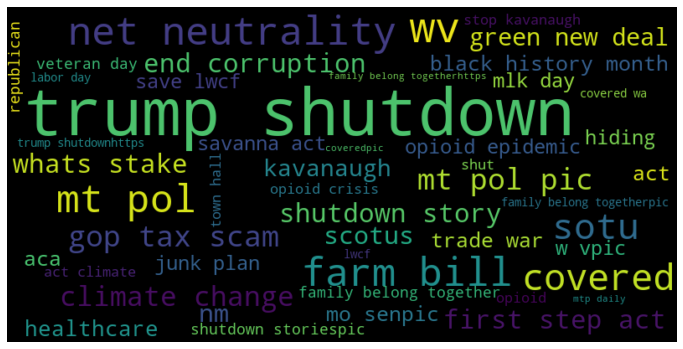

In [171]:
#WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_dem)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

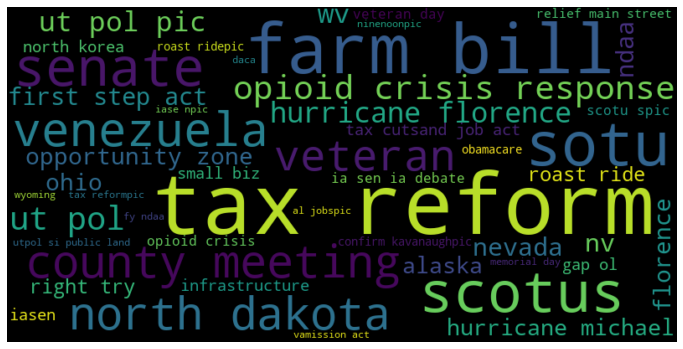

In [172]:
#WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_rep)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [174]:
senator_tweet_data['combined_text'] = senator_tweet_data['clean_text'] + senator_tweet_data['Segmented#'].apply(str.split)

In [187]:
senator_tweet_data.to_pickle('preprocessed_senator_tweet_data.pkl', protocol=4)

In [190]:
senator_tweet_data.to_csv('preprocessed_senator_tweet_data.csv')

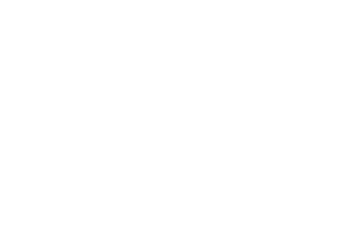

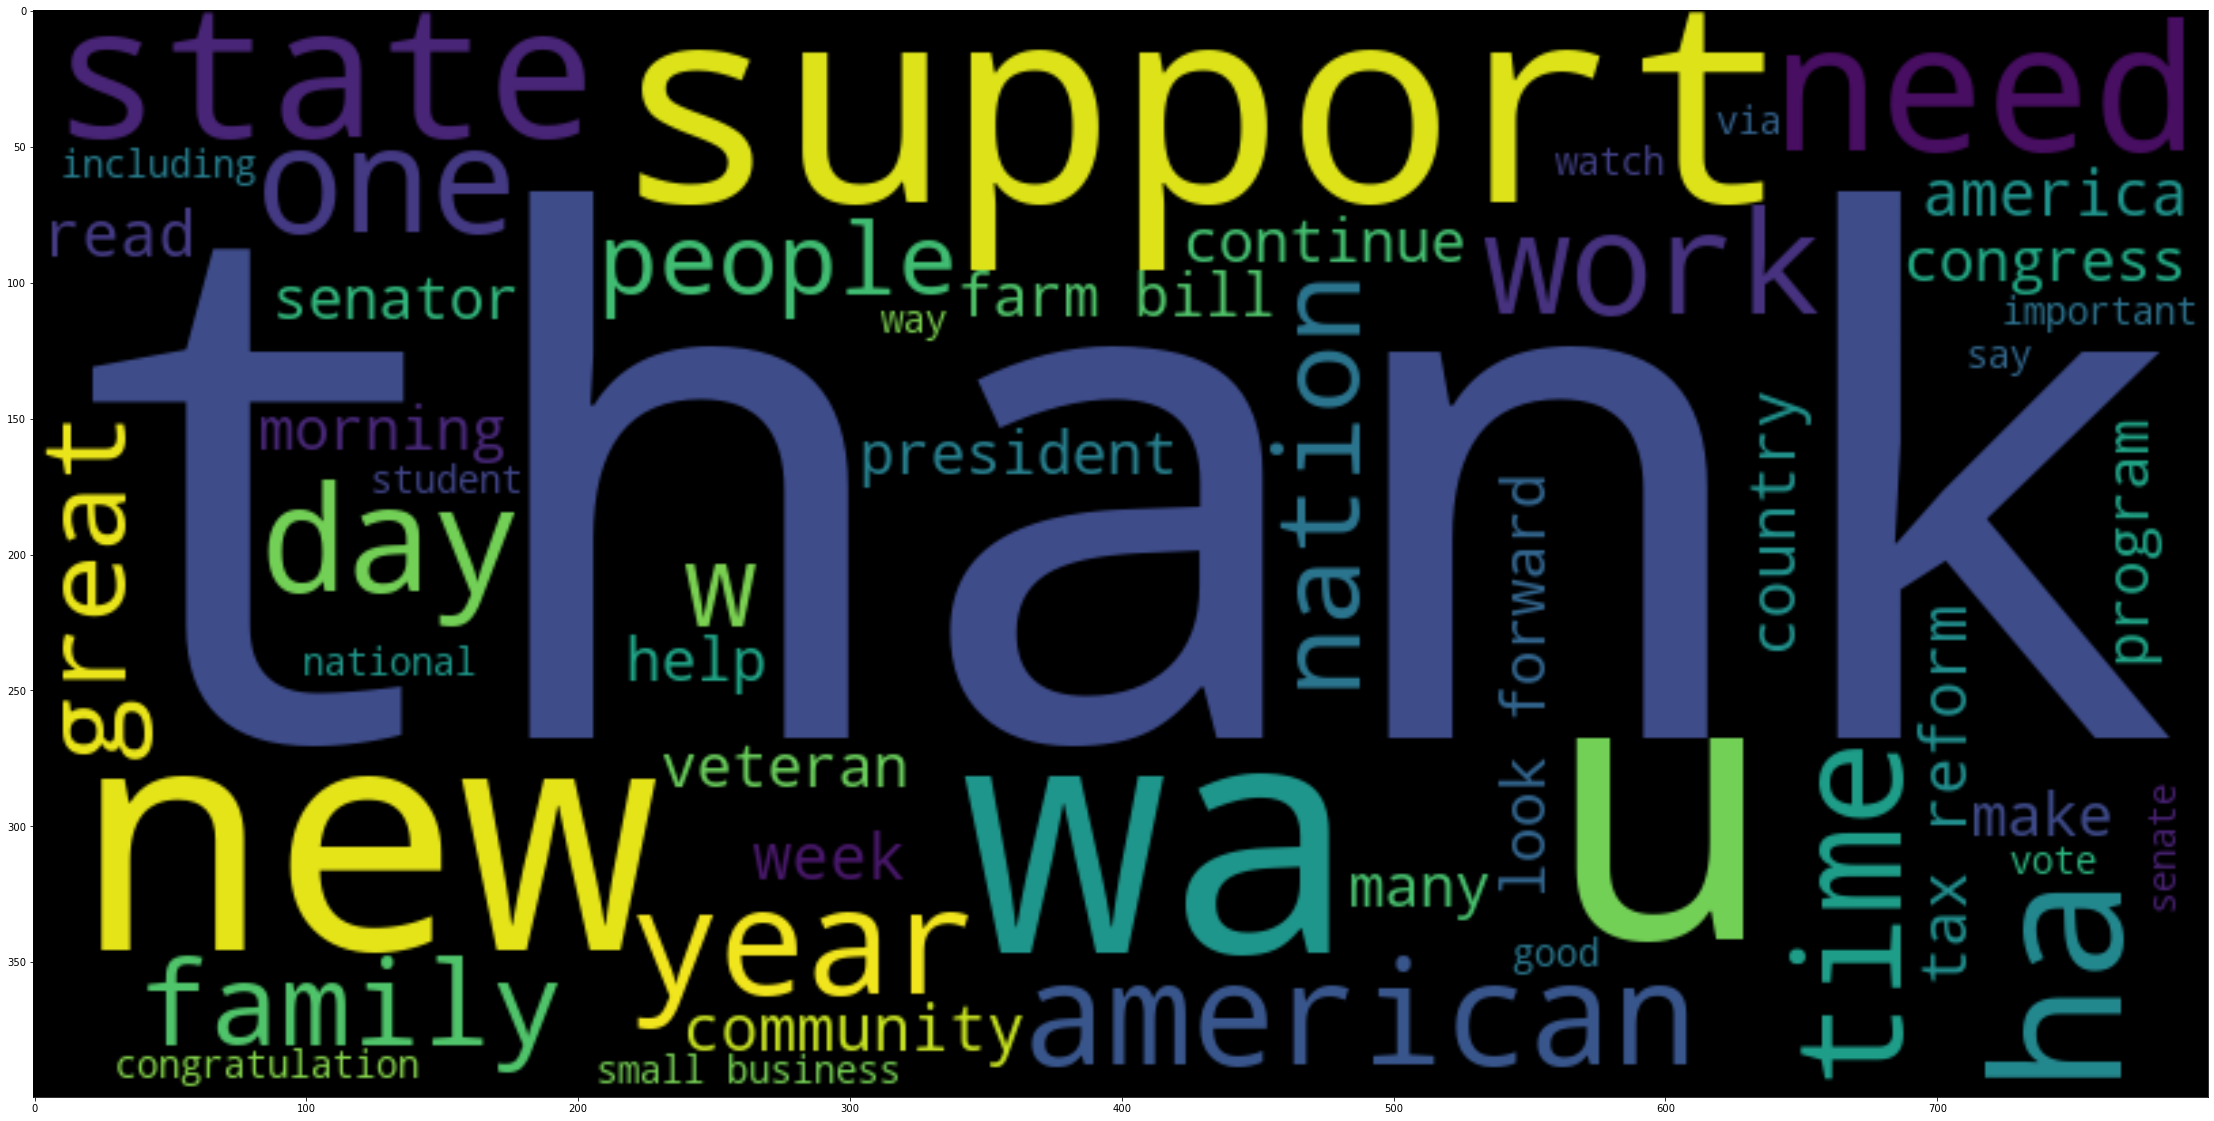

In [175]:
wordcloud = WordCloud(width=800, height=400, max_words=50).generate(' '.join([' '.join(map(str, l)) for l in senator_tweet_data[senator_tweet_data.party == 'Republican']['combined_text']]))
plt.axis("off")
plt.figure( figsize=(40,20))
# plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

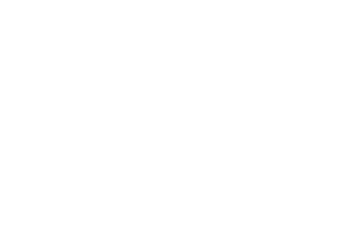

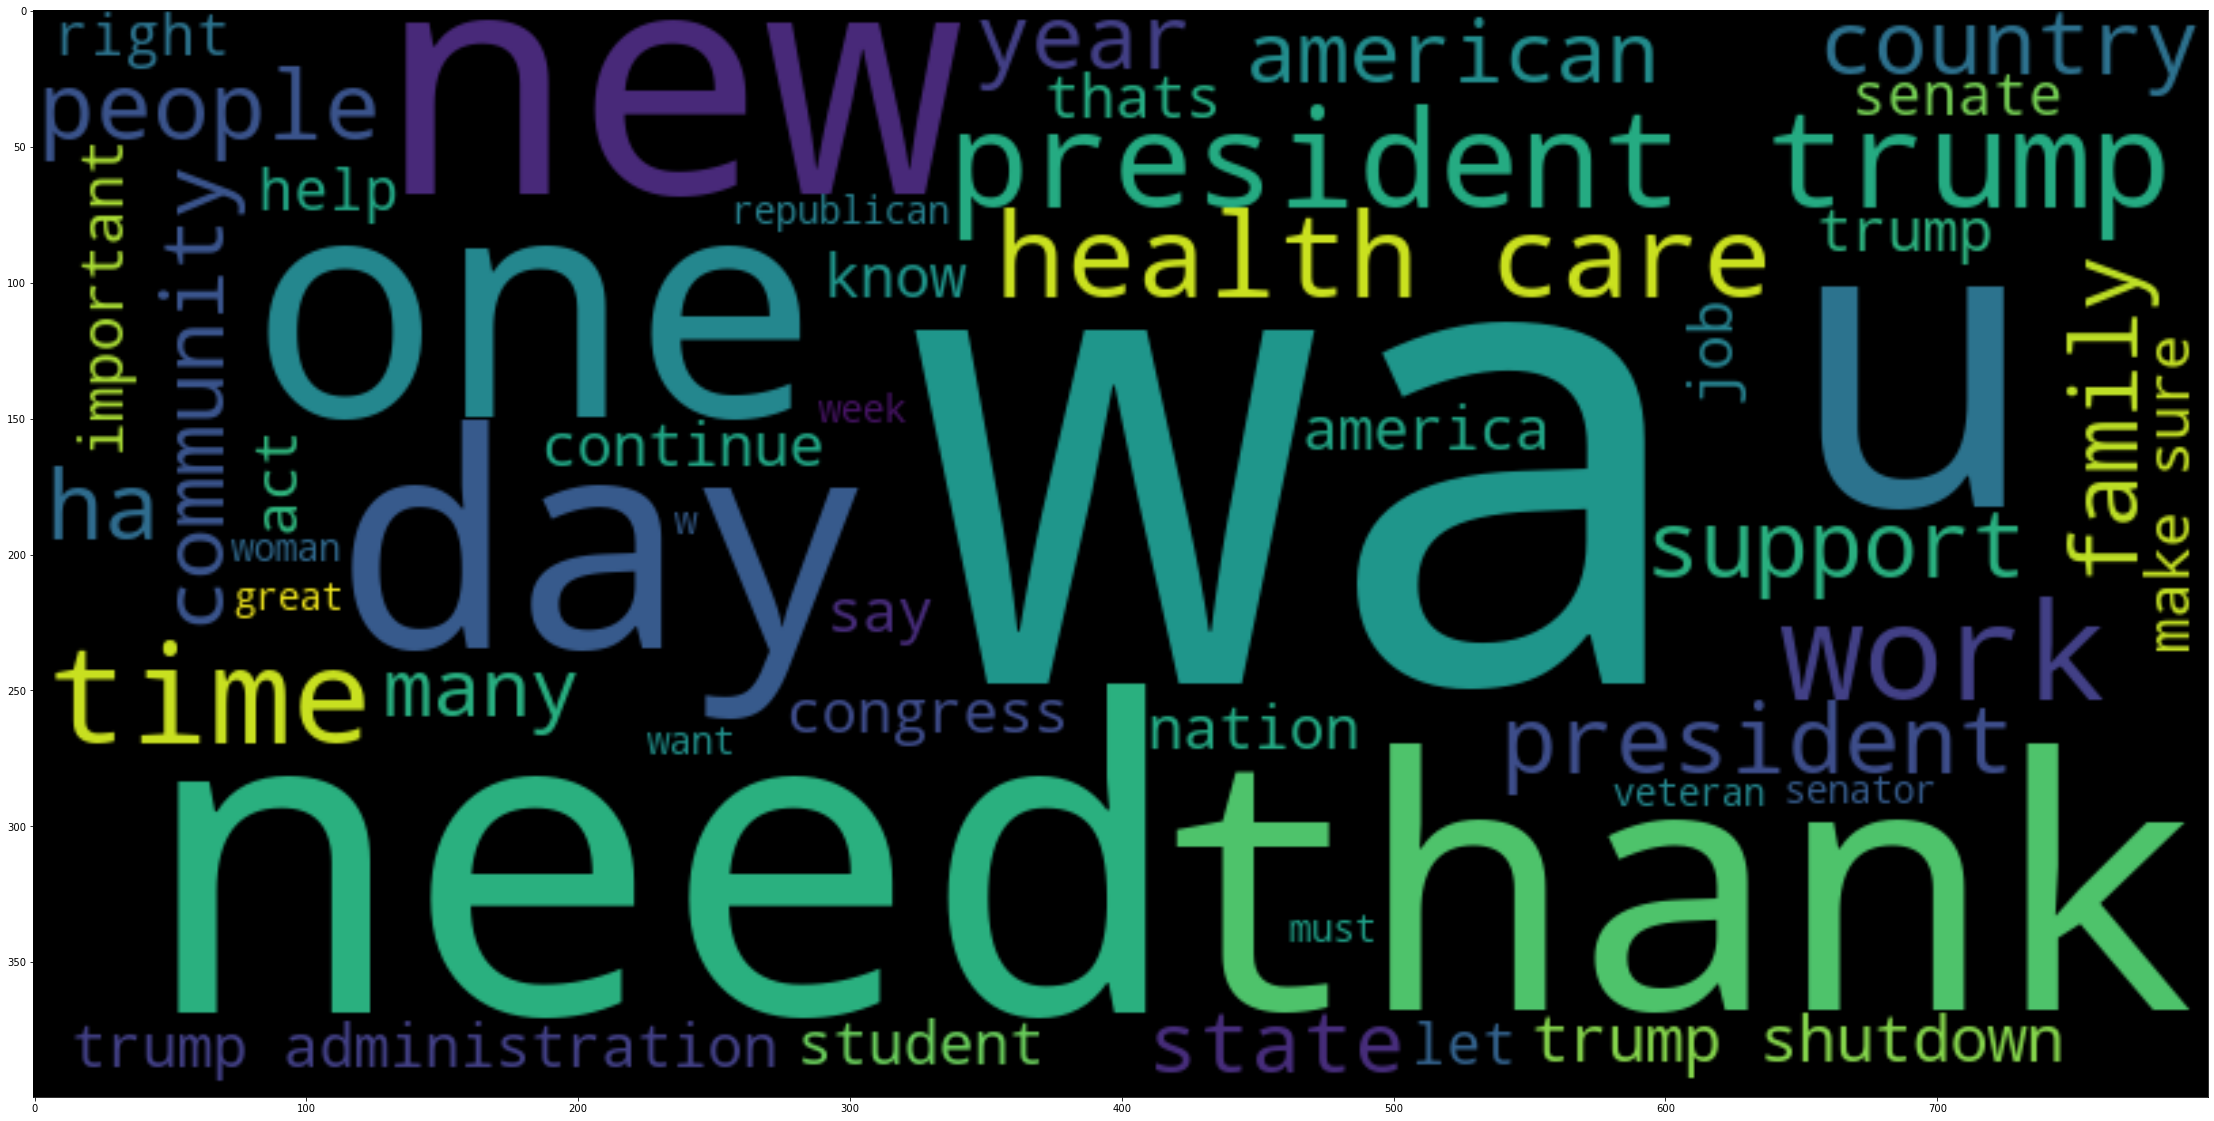

In [176]:
wordcloud = WordCloud(width=800, height=400, max_words=50).generate(' '.join([' '.join(map(str, l)) for l in senator_tweet_data[senator_tweet_data.party == 'Democrat']['combined_text']]))
plt.axis("off")
plt.figure( figsize=(40,20))
# plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

We don't need to do Phrase parsing here as Twitter is a short form text platform. However, should explore bigrams

Need to check if the orphan tweets are related or not

Algos to check - TF-IDF, WordVec & Glove

Question to check: can a tweet predict the party affiliation of a senator?

In [188]:
senator_tweet_data =pd.read_pickle('preprocessed_senator_tweet_data.pkl')

### EDA

In [189]:
senator_tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79409 entries, 0 to 79408
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fullname       79409 non-null  object        
 1   user           79409 non-null  object        
 2   text           79409 non-null  object        
 3   retweets       79409 non-null  int64         
 4   likes          79409 non-null  int64         
 5   replies        79409 non-null  int64         
 6   timestamp      79409 non-null  datetime64[ns]
 7   party          79409 non-null  object        
 8   hashtag        79409 non-null  object        
 9   clean_text     79409 non-null  object        
 10  Segmented#     79409 non-null  object        
 11  combined_text  79409 non-null  object        
 12  word_count     79409 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(8)
memory usage: 7.9+ MB


In [180]:
import pyrsm as rsm

In [181]:
senator_tweet_data.party.value_counts()

Republican    40747
Democrat      38662
Name: party, dtype: int64

In [182]:
import seaborn as sns

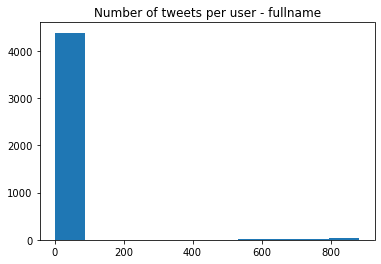

In [183]:
plt.hist(senator_tweet_data.fullname.value_counts());
plt.title('Number of tweets per user - fullname');

In [184]:
senator_tweet_data.fullname.value_counts()[senator_tweet_data.fullname.value_counts() > 150]

Leader McConnell                883
Rob Portman                     853
ChuckGrassley                   850
Amy Klobuchar                   842
Archive: Sen. Heidi Heitkamp    838
                               ... 
Senate Republicans              349
Sen. Ag Republicans             219
Senate Democrats                211
Team Joni                       179
Fox News                        156
Name: fullname, Length: 101, dtype: int64

In [81]:
# from ast import literal_eval

In [83]:
# senator_tweet_data.combined_text = senator_tweet_data.combined_text.apply(literal_eval)

In [185]:
senator_tweet_data['word_count'] = senator_tweet_data.combined_text.apply(len)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

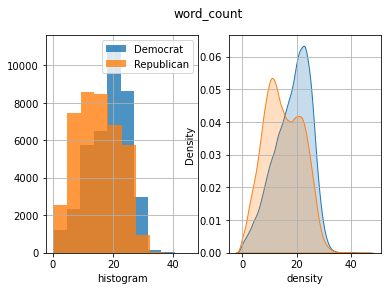

In [186]:
x, y = "word_count", "party"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in senator_tweet_data[y].unique():
    sns.distplot(senator_tweet_data[senator_tweet_data[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(senator_tweet_data[senator_tweet_data[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(senator_tweet_data[y].unique())
ax[1].grid(True)
plt.show();